
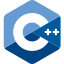
<br>

<div style="text-align:center; font-size:200%;">
  <b>Design Patterns for Testable Code</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 02 Design Patterns for Testable Code.ipynb -->
<!-- slides/module_410_unit_testing/topic_210_design_patterns_for_tests.cpp -->


## Seams

- Points in the code where we can change behavior for testing without
  modifying the code itself.
- Important for introducing test doubles.
- Examples:
  - Virtual functions/interfaces
  - Template parameters
  - Function pointers
  - Functions from dynamic libraries


## Patterns for Testability

- **Dependency Injection (DI)**
  - Introduces seams by injecting dependencies from the outside.
- **Dependency Inversion Principle (DIP):**
  - Allows controlling the direction of dependencies.
  - Introduces interfaces that improve testability.
- **Humble Object Pattern:**
  - Isolates complex, hard-to-test logic from the outside world.


### Dependency Injection

- A class should not create its own dependencies.
- Instead, they are "injected" from the outside (e.g., via the constructor).

In [ ]:
#include <iostream>
#include <memory>

In [ ]:
class IDependency
{
public:
    virtual ~IDependency() = default;
    virtual void perform_work() const = 0;
};

In [ ]:
class Dependency : public IDependency
{
public:
    void perform_work() const override
    {
        std::cout << "Performing work in Dependency" << std::endl;
    }
};

In [ ]:
class MyClassWithoutDI
{
public:
    MyClassWithoutDI() : dependency{std::make_unique<Dependency>()} {}

    void do_something() const { dependency->perform_work(); }

private:
    std::unique_ptr<IDependency> dependency;
};


# Dependency Inversion Principle

- The core functionality of a system does not depend on its environment
  - **Concrete artifacts depend on abstractions** (not vice versa)
  - **Unstable artifacts depend on stable artifacts** (not vice versa)
  - **Outer layers** of the architecture **depend on inner layers** (not vice
    versa)
  - Classes/Modules depend on abstractions (e.g., interfaces) not on other
    classes/modules
- Dependency inversion achieves this by introducing interfaces that “reverse
  the dependencies”


## Dependencies

- We have to distinguish two kinds of dependencies:
  - Data and control flow
  - Source code dependencies
- Data and control flow dependencies are inherent in the logic
- Source code dependencies can be controlled by the architecture


The source code dependency goes in the same direction as the data flow:

`MyModule.cpp` ⟹ `Database.h`

<img src="img/db-example-01.svg"
     style="display:block;margin:auto;width:75%"/>


### Before
<img src="img/dependency-01.svg"
     style="display:block;margin:auto;width:75%"/>

### After
<img src="img/dependency-02.svg"
     style="display:block;margin:auto;width:75%"/>


<img src="img/dip-01.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-02.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-03.svg"
     style="display:block;margin:auto;width:95%"/>


## How DIP and DI work together:

- DIP: abstract interface
- DI: injection of the concrete implementation at runtime

**Effect:** Ability to bring test doubles into play


### Humble Object Pattern

**Problem:**
- How do you test code that is heavily intertwined with "inconvenient"
  infrastructure?
  - UI
  - Database
  - API
  - ...


### Humble Object Pattern

**Solution:** Split the class into two parts:
1.  **The Humble Object:**
    - A very thin wrapper at the boundary to the external system.
    - Contains *no* logic (no `if` statements, loops, etc.).
    - Its only job: shuttle data back and forth.
    - Is so simple that it doesn't need to be tested.

2.  **The Testable Logic:**
    - All the complex code (business logic, decisions).
    - Is extracted into a separate class that has no knowledge of the infrastructure.
    - This class is easily and fully testable.


## Refactoring to a Humble Object

**Goal:** Refactor a hard-to-test class that mixes business logic and external
dependencies using the Humble Object pattern.

**Scenario:** An `OrderProcessor` that:

- reads order data from a file,
- calculates discounts and checks inventory,
- saves orders to a database,
- updates inventory.

This is difficult to test because it depends on file system and database.


Here is the class we will refactor. Notice how the business logic
is mixed with external dependencies.

In [ ]:
#include "check.h"
#include <fstream>
#include <iostream>
#include <sstream>
#include <stdexcept>
#include <string>
#include <vector>

In [ ]:
namespace order_processor
{
struct Order
{
    std::string customer_type; // "premium", "regular"
    std::string product;
    int quantity;
    double unit_price;
    double total_price;
    bool is_valid;
};
} // namespace order_processor

In [ ]:
namespace non_humble_order_processor
{
using namespace order_processor;

class OrderProcessor
{
public:
    void process_orders_from_file(const std::string& file_path);

private:
    Order parse_order_line(const std::string& line);

    // Business logic - should be easily testable
    double calculate_discount(const std::string& customer_type, int quantity);

    // Infrastructure - hard to test (simulates database lookup)
    bool check_inventory(const std::string& product, int quantity);

    // Infrastructure - hard to test
    void save_order_to_database(const Order& order);

    // Infrastructure - hard to test
    void update_inventory(const std::string& product, int quantity);
};
} // namespace non_humble_order_processor

In [ ]:
namespace non_humble_order_processor
{
void OrderProcessor::process_orders_from_file(const std::string& file_path)
{
    // 1. Read from file (infrastructure)
    std::ifstream file(file_path);
    if (!file)
    {
        throw std::runtime_error("Could not open file");
    }

    std::string line;
    while (std::getline(file, line))
    {
        // 2. Parse order data
        Order order = parse_order_line(line);

        // 3. Business logic: Check inventory
        if (!check_inventory(order.product, order.quantity))
        {
            std::cout << "Not enough inventory for " << order.product << std::endl;
            continue;
        }

        // 4. Business logic: Calculate discount and total
        double discount = calculate_discount(order.customer_type, order.quantity);
        order.total_price = (order.unit_price * order.quantity) * (1.0 - discount);
        order.is_valid = true;

        // 5. Save to database (infrastructure)
        save_order_to_database(order);

        // 6. Update inventory (infrastructure)
        update_inventory(order.product, order.quantity);

        std::cout << "Processed order: " << order.product << " for $"
                  << order.total_price << std::endl;
    }
}
} // namespace non_humble_order_processor

In [ ]:
namespace non_humble_order_processor
{
Order OrderProcessor::parse_order_line(const std::string& line)
{
    std::stringstream ss(line);
    std::string customer_type, product, quantity_str, price_str;

    std::getline(ss, customer_type, ',');
    std::getline(ss, product, ',');
    std::getline(ss, quantity_str, ',');
    std::getline(ss, price_str, ',');

    return {customer_type,        product, std::stoi(quantity_str),
            std::stod(price_str), 0.0,     false};
}
} // namespace non_humble_order_processor

In [ ]:
namespace non_humble_order_processor
{
double OrderProcessor::calculate_discount(
    const std::string& customer_type, int quantity
)
{
    double discount = 0.0;
    if (customer_type == "premium")
    {
        discount += 0.1; // 10% for premium
    }
    if (quantity >= 10)
    {
        discount += 0.05; // 5% for bulk
    }
    return std::min(discount, 0.15); // Max 15% discount
}
} // namespace non_humble_order_processor

In [ ]:
namespace non_humble_order_processor
{
bool OrderProcessor::check_inventory(const std::string& product, int quantity)
{
    std::cout << "Checking inventory for " << product << std::endl;
    return quantity <= 100; // Simulate inventory check
}
} // namespace non_humble_order_processor

In [ ]:
namespace non_humble_order_processor
{
void OrderProcessor::save_order_to_database(const Order& order)
{
    std::cout << "Saving order to database" << std::endl;
    // Simulate database save
}
} // namespace non_humble_order_processor

In [ ]:
namespace non_humble_order_processor
{
void OrderProcessor::update_inventory(const std::string& product, int quantity)
{
    std::cout << "Updating inventory: -" << quantity << " " << product << std::endl;
    // Simulate inventory update
}
} // namespace non_humble_order_processor

In [ ]:
namespace non_humble_order_processor
{
void demonstrate_non_humble_order_processor()
{
    OrderProcessor processor;
    try
    {
        processor.process_orders_from_file("orders.txt");
    }
    catch (const std::runtime_error& e)
    {
        std::cerr << "Error: " << e.what() << std::endl;
    }
}
} // namespace non_humble_order_processor


### Refactor & Test

1.  **Extracting the Business Logic:** We create an `OrderService` class
    that encapsulates the pure business logic (discount calculation, price
    calculation).
2.  **Creating the Humble Object:** The original `OrderProcessor` becomes the
    Humble Object. It only handles I/O and delegates business logic.
3.  **Abstracting the Infrastructure:** We use interfaces for database and
    inventory service.
4.  **Writing Tests:** We write unit tests for the `OrderService` class.

In [ ]:
// Solution:
namespace humble_order_processor
{
// Interfaces for external dependencies
class IInventoryService
{
public:
    virtual ~IInventoryService() = default;
    virtual bool has_stock(const std::string& product, int quantity) = 0;
    virtual void reduce_stock(const std::string& product, int quantity) = 0;
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
using namespace order_processor;

class IOrderRepository
{
public:
    virtual ~IOrderRepository() = default;
    virtual void save(const Order& order) = 0;
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
// 1. Pure business logic - easily testable
class OrderService
{
private:
    IInventoryService* inventory;
    IOrderRepository* repository;

public:
    OrderService(IInventoryService* inv, IOrderRepository* repo)
        : inventory(inv), repository(repo)
    {}

    void process_order(const Order& raw_order);

    // Business logic methods - easily testable
    Order calculate_order_total(const Order& raw_order);

    double calculate_discount(const std::string& customer_type, int quantity);
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
void OrderService::process_order(const Order& raw_order)
{
    // ALL business logic and orchestration here
    if (!inventory->has_stock(raw_order.product, raw_order.quantity))
    {
        std::cout << "Not enough inventory for " << raw_order.product << std::endl;
        return; // Business decision: skip this order
    }

    // Calculate order total with business rules
    Order processed_order = calculate_order_total(raw_order);

    // Execute business workflow
    repository->save(processed_order);
    inventory->reduce_stock(processed_order.product, processed_order.quantity);

    std::cout << "Processed order: " << processed_order.product << " for $"
              << processed_order.total_price << std::endl;
}
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
Order OrderService::calculate_order_total(const Order& raw_order)
{
    Order processed_order = raw_order;

    double discount = calculate_discount(raw_order.customer_type, raw_order.quantity);
    processed_order.total_price =
        (raw_order.unit_price * raw_order.quantity) * (1.0 - discount);
    processed_order.is_valid = true;

    return processed_order;
}

} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
double OrderService::calculate_discount(const std::string& customer_type, int quantity)
{
    double discount = 0.0;
    if (customer_type == "premium")
    {
        discount += 0.1; // 10% for premium
    }
    if (quantity >= 10)
    {
        discount += 0.05; // 5% for bulk
    }
    return std::min(discount, 0.15); // Max 15% discount
}
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
// 2. Humble Object - only handles infrastructure
class OrderProcessor
{
private:
    OrderService* order_service;

public:
    OrderProcessor(OrderService* service) : order_service(service) {}

    void process_orders_from_file(const std::string& file_path);

private:
    Order parse_order_line(const std::string& line);
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
void OrderProcessor::process_orders_from_file(const std::string& file_path)
{
    // ONLY handles file I/O - no business decisions
    std::ifstream file(file_path);
    if (!file)
    {
        throw std::runtime_error("Could not open file");
    }

    std::string line;
    while (std::getline(file, line))
    {
        // Just parse and delegate - NO logic or decisions
        Order raw_order = parse_order_line(line);
        order_service->process_order(raw_order);
    }
}
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
Order OrderProcessor::parse_order_line(const std::string& line)
{
    std::stringstream ss(line);
    std::string customer_type, product, quantity_str, price_str;

    std::getline(ss, customer_type, ',');
    std::getline(ss, product, ',');
    std::getline(ss, quantity_str, ',');
    std::getline(ss, price_str, ',');

    return {customer_type,        product, std::stoi(quantity_str),
            std::stod(price_str), 0.0,     false};
}
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
// 3. Test implementations
class MockInventoryService : public IInventoryService
{
public:
    bool has_stock(const std::string& product, int quantity) override
    {
        return quantity <= 50; // Mock: always in stock if <= 50
    }

    void reduce_stock(const std::string& product, int quantity) override
    {
        // std::cout << "Mock: Reduced " << quantity << " " << product << std::endl;
    }
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
class MockOrderRepository : public IOrderRepository
{
public:
    std::vector<Order> saved_orders;

    void save(const Order& order) override { saved_orders.push_back(order); }
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
// 4. Unit tests for pure business logic
void test_order_service()
{
    MockInventoryService mock_inventory;
    MockOrderRepository mock_repository;
    OrderService service(&mock_inventory, &mock_repository);

    // Test successful order processing
    Order test_order{"premium", "laptop", 5, 1000.0, 0.0, false};
    service.process_order(test_order);

    check(mock_repository.saved_orders.size() == 1, "Order should be saved");
    check(
        mock_repository.saved_orders[0].total_price == 4500.0,
        "Premium customer should get 10% discount: 5000 * 0.9 = 4500"
    );

    // Test business logic calculations
    Order bulk_order{"regular", "mouse", 15, 20.0, 0.0, false};
    Order result = service.calculate_order_total(bulk_order);
    check(result.total_price == 285.0, "Bulk order should get 5% discount");

    // Test combined discounts (capped at 15%)
    Order premium_bulk{"premium", "keyboard", 20, 100.0, 0.0, false};
    Order combined_result = service.calculate_order_total(premium_bulk);
    check(combined_result.total_price == 1700.0, "Combined discounts capped at 15%");

    std::cout << "All OrderService tests passed!" << std::endl;
}
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
class DemoInventoryService : public IInventoryService
{
public:
    bool has_stock(const std::string& product, int quantity) override
    {
        std::cout << "Checking inventory for " << product << std::endl;
        return quantity <= 100; // Simulate inventory check
    }

    void reduce_stock(const std::string& product, int quantity) override
    {
        std::cout << "Reducing stock for " << product << " by " << quantity
                  << std::endl;
        // Simulate inventory reduction
    }
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
class DemoOrderRepository : public IOrderRepository
{
public:
    void save(const Order& order) override
    {
        std::cout << "Saving order to database: " << order.product << " for $"
                  << order.total_price << std::endl;
        // Simulate database save
    }
};
} // namespace humble_order_processor

In [ ]:
namespace humble_order_processor
{
void demonstrate_humble_object()
{
    // Create services
    DemoInventoryService inventory_service;
    DemoOrderRepository order_repository;

    // Create the business logic service
    OrderService order_service(&inventory_service, &order_repository);

    // Create the humble object
    OrderProcessor processor(&order_service);

    // Process orders from a file (simulated)
    try
    {
        processor.process_orders_from_file("orders.txt");
    }
    catch (const std::runtime_error& e)
    {
        std::cerr << "Error: " << e.what() << std::endl;
    }
}
} // namespace humble_order_processor


## Workshop: Refactoring to a Humble Object

**Goal:** Refactor a hard-to-test class that mixes business logic and external
dependencies using the Humble Object pattern.

**Scenario:** A `UserRegistrationService` that:

- reads user data from a file,
- applies validation and business rules,
- saves users to a database,
- sends email notifications.

This is difficult to test because it depends on file system, database, and email
service.


Here is the class we will refactor. Notice how the business logic
is mixed with external dependencies.

In [ ]:
#include "check.h"
#include <fstream>
#include <iostream>
#include <sstream>
#include <stdexcept>
#include <string>
#include <vector>

In [ ]:
struct User
{
    std::string name;
    std::string email;
    int age;
    std::string role;
};

In [ ]:
// Original monolithic class - hard to test
class UserRegistrationService
{
public:
    void register_users_from_file(const std::string& file_path)
    {
        // 1. Read from file (infrastructure)
        std::ifstream file(file_path);
        if (!file)
        {
            throw std::runtime_error("Could not open file");
        }

        std::string line;
        while (std::getline(file, line))
        {
            // 2. Parse user data (could be business logic)
            User user = parse_user_line(line);

            // 3. Business logic validation
            if (!is_valid_user(user))
            {
                std::cout << "Invalid user: " << user.name << std::endl;
                continue;
            }

            // 4. Apply business rules
            std::string assigned_role = assign_role(user);
            user.role = assigned_role;

            // 5. Save to database (infrastructure)
            save_to_database(user);

            // 6. Send email (infrastructure)
            send_welcome_email(user);
        }
    }

private:
    User parse_user_line(const std::string& line)
    {
        std::stringstream ss(line);
        std::string name, email, age_str;

        std::getline(ss, name, ',');
        std::getline(ss, email, ',');
        std::getline(ss, age_str, ',');

        return {name, email, std::stoi(age_str), ""};
    }

    // Business logic - should be easily testable
    bool is_valid_user(const User& user)
    {
        return !user.name.empty() && user.email.find('@') != std::string::npos &&
               user.age >= 18 && user.age <= 120;
    }

    // Business logic - should be easily testable
    std::string assign_role(const User& user)
    {
        if (user.age >= 65)
        {
            return "senior";
        }
        if (user.age >= 18)
        {
            return "adult";
        }
        return "minor";
    }

    // Infrastructure - hard to test
    void save_to_database(const User& user)
    {
        std::cout << "Saving to DB: " << user.name << std::endl;
        // Simulate database save
    }

    // Infrastructure - hard to test
    void send_welcome_email(const User& user)
    {
        std::cout << "Sending email to: " << user.email << std::endl;
        // Simulate email sending
    }
};

In [ ]:
void demonstrate_user_registration_service()
{
    UserRegistrationService service;
    try
    {
        service.register_users_from_file("users.txt");
    }
    catch (const std::runtime_error& e)
    {
        std::cerr << "Error: " << e.what() << std::endl;
    }
}


### Your Task: Refactor & Test

1.  **Extract the Business Logic:** Create a `UserProcessor` class that encapsulates
the pure business logic (validation, role assignment).
2.  **Create the Humble Object:** The original `UserRegistrationService` becomes
the Humble Object. It only handles I/O and delegates business logic.
3.  **Abstract the Infrastructure:** Use interfaces for database and email service
to improve testability.
4.  **Write Tests:** Write unit tests for the `UserProcessor` class.